# Approximate Bayesian Computation

Think Bayes, Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install libraries

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [1]:
# Get utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

In [2]:
from utils import set_pyplot_params
set_pyplot_params()

This chapter introduces a method of last resort for the most complex problems, Approximate Bayesian Computation (ABC).
I say it is a last resort because it usually requires more computation than other methods, so if you can solve a problem any other way, you should.
However, for the examples in this chapter, ABC is not just easy to implement; it is also efficient.

The first example is my solution to a problem posed by a patient
with a kidney tumor.
I use data from a medical journal to model tumor growth, and use simulations to estimate the age of a tumor based on its size.

The second example is a model of cell counting, which has applications in biology, medicine, and zymurgy (beer-making).
Given a cell count from a diluted sample, we estimate the concentration of cells.

Finally, as an exercise, you'll have a chance to work on a fun sock-counting problem.


本章介绍了解决最复杂问题的最后一种方法，近似贝叶斯计算 (ABC)。
我说这是最后的手段，因为它通常比其他方法需要更多的计算，所以如果你可以用其他方法解决问题，你应该这样做。
但是，对于本章中的示例，ABC 不仅易于实现；它也很有效。

第一个例子是我对一个病人提出的问题的解决方案
患有肾肿瘤。
我使用来自医学杂志的数据来模拟肿瘤生长，并使用模拟根据肿瘤的大小来估计肿瘤的年龄。

第二个例子是细胞计数模型，它在生物学、医学和 zymurgy（啤酒制造）中有应用。
给定稀释样品的细胞计数，我们估计细胞浓度。

最后，作为一个练习，你将有机会解决一个有趣的袜子计数问题。

## The Kidney Tumor Problem

I am a frequent reader and occasional contributor to the online
statistics forum at <http://reddit.com/r/statistics>. 
In November 2011, I read the following message:

> "I have Stage IV Kidney Cancer and am trying to determine if the cancer formed before I retired from the military. ... Given the dates of retirement and detection is it possible to determine when there was a 50/50 chance that I developed the disease? Is it possible to determine the probability on the retirement date? My tumor was 15.5 cm x 15 cm at detection. Grade II."

I contacted the author of the message to get more information; I
learned that veterans get different benefits if it is "more likely than not" that a tumor formed while they were in military service (among other considerations).
So I agree to help him answer his question.

Because renal tumors grow slowly, and often do not cause symptoms, they are sometimes left untreated. As a result, doctors can observe the rate of growth for untreated tumors by comparing scans from the same patient at different times. Several papers have reported these growth rates.

For my analysis I used data from a paper by [Zhang et al](https://pubs.rsna.org/doi/full/10.1148/radiol.2501071712). 
They report growth rates in two forms:

* Volumetric doubling time, which is the time it would take for a tumor to double in size.

* Reciprocal doubling time (RDT), which is the number of doublings per year.

The next section shows how we work with these growth rates.

## 肾肿瘤问题

我是在线的常客和偶尔的贡献者
<http://reddit.com/r/statistics> 上的统计论坛。
2011 年 11 月，我读到以下消息：

> “我患有 IV 期肾癌，并试图确定癌症是否在我从军队退役之前形成。......鉴于退休和检测日期，是否有可能确定我何时有 50/50 的机会发展“是什么病？能确定退休日期的概率吗？我的肿瘤在检测时是15.5 cm x 15 cm。II级。”

我联系了消息的作者以获取更多信息；我
了解到，如果退伍军人在服兵役期间“更有可能”形成肿瘤（以及其他考虑因素），则会获得不同的好处。
所以我同意帮助他回答他的问题。

由于肾肿瘤生长缓慢，并且通常不会引起症状，因此有时不予治疗。因此，医生可以通过比较同一患者在不同时间的扫描结果来观察未治疗肿瘤的生长速度。几篇论文已经报道了这些增长率。

对于我的分析，我使用了 [Zhang 等人](https://pubs.rsna.org/doi/full/10.1148/radiol.2501071712) 的论文中的数据。
他们以两种形式报告增长率：

* 体积倍增时间，即肿瘤体积倍增所需的时间。

* 倒数倍增时间 (RDT)，即每年的倍增次数。

下一节将展示我们如何处理这些增长率。

Zhang et al, Distribution of Renal Tumor Growth Rates Determined
    by Using Serial Volumetric CT Measurements, January 2009
    *Radiology*, 250, 137-144.
    
https://pubs.rsna.org/doi/full/10.1148/radiol.2501071712

## A Simple Growth Model

We'll start with a simple model of tumor growth based on two assumptions:

* Tumors grow with a constant doubling time, and 

* They are roughly spherical in shape.

And I'll define two points in time:

* `t1` is when my correspondent retired.

* `t2` is when the tumor was detected.

The time between `t1` and `t2` was about 9.0 years.
As an example, let's assume that the diameter of the tumor was 1 cm at `t1`, and estimate its size at `t2`.

I'll use the following function to compute the volume of a sphere with a given diameter.

## 一个简单的增长模型

我们将从一个基于两个假设的简单肿瘤生长模型开始：

* 肿瘤以恒定的倍增时间生长，并且

* 它们大致呈球形。

我将定义两个时间点：

* `t1` 是我的通讯员退休的时间。

* `t2` 是检测到肿瘤的时间。

`t1` 和 `t2` 之间的时间大约是 9.0 年。
举个例子，我们假设在 t1 时肿瘤的直径是 1 cm，然后在 t2 估计它的大小。

我将使用以下函数来计算给定直径的球体的体积。

In [3]:
import numpy as np

def calc_volume(diameter):
    """Converts a diameter to a volume."""
    factor = 4 * np.pi / 3
    return factor * (diameter/2.0)**3

Assuming that the tumor is spherical, we can compute its volume at `t1`.

假设肿瘤是球形的，我们可以计算它在“t1”处的体积。

In [4]:
d1 = 1
v1 = calc_volume(d1)
v1

0.5235987755982988

The median volume doubling time reported by Zhang et al. is 811 days, which corresponds to an RDT of 0.45 doublings per year.

Zhang 等人 报告的中位体积倍增时间。是 811 天，这对应于每年 0.45 倍的 RDT。

In [5]:
median_doubling_time = 811
rdt = 365 / median_doubling_time
rdt

0.45006165228113443

We can compute the number of doublings that would have happened in the interval between `t1` and `t2`:

我们可以计算在 `t1` 和 `t2` 之间的时间间隔内发生的加倍次数：

In [6]:
interval = 9.0
doublings = interval * rdt
doublings

4.05055487053021

Given `v1` and the number of doublings, we can compute the volume at `t2`.

给定 `v1` 和倍增次数，我们可以计算 `t2` 处的体积。

In [7]:
v2 = v1 * 2**doublings
v2

8.676351488087187

The following function computes the diameter of a sphere with the given volume.

以下函数计算具有给定体积的球体的直径。

In [8]:
def calc_diameter(volume):
    """Converts a volume to a diameter."""
    factor = 3 / np.pi / 4
    return 2 * (factor * volume)**(1/3)

So we can compute the diameter of the tumor at `t2`:

所以我们可以计算 t2 处肿瘤的直径：

In [9]:
d2 = calc_diameter(v2)
d2

2.5494480788327483

If the diameter of the tumor was 1 cm at `t1`, and it grew at the median rate, the diameter would be about 2.5 cm at `t2`.

This example demonstrates the growth model, but it doesn't answer the question my correspondent posed.

如果在`t1`时肿瘤的直径为1 cm，并且以中等速度生长，则在`t2`时直径约为2.5 cm。

这个例子演示了增长模型，但它没有回答我的通讯员提出的问题。

## A More General Model

Given the size of a tumor at time of diagnosis, we would like to know the distribution of its age.
To find it, we'll run simulations of tumor growth to get the distribution of size conditioned on age. 
Then we'll compute the distribution of age conditioned on size.

The simulation starts with a small tumor and runs these steps:

1.  Choose a value from the distribution of growth rates.

2.  Compute the size of the tumor at the end of an interval.

3.  Repeat until the tumor exceeds the maximum relevant size.

So the first thing we need is the distribution of growth rates.

## 更通用的模型

鉴于诊断时肿瘤的大小，我们想知道它的年龄分布。
为了找到它，我们将对肿瘤生长进行模拟，以获得以年龄为条件的大小分布。
然后我们将计算以大小为条件的年龄分布。

模拟从一个小肿瘤开始并运行以下步骤：

1. 从增长率分布中选择一个值。

2. 计算间隔结束时肿瘤的大小。

3. 重复直到肿瘤超过最大相关尺寸。

所以我们首先需要的是增长率的分布。

Using the figures in the paper by Zhange et al., I created an array, `rdt_sample`, that contains estimated values of RDT for the 53 patients in the study.

Again, RDT stands for "reciprocal doubling time", which is in doublings per year.
So if `rdt=1`, a tumor would double in volume in one year.
If `rdt=2`, it would double twice; that is, the volume would quadruple.
And if `rdt=-1`, it would halve in volume.

使用 Zhange 等人的论文中的数据，我创建了一个数组“rdt_sample”，其中包含研究中 53 名患者的 RDT 估计值。

同样，RDT 代表“倒数倍增时间”，即每年翻倍。
因此，如果“rdt=1”，肿瘤体积会在一年内翻倍。
如果`rdt=2`，它会加倍；也就是说，体积会翻两番。
如果 `rdt=-1`，它的体积会减半。

In [10]:
# Data from the histogram in Figure 3

import numpy as np
from empiricaldist import Pmf

counts = [2, 29, 11, 6, 3, 1, 1]
rdts = np.arange(-1, 6) + 0.01
pmf_rdt = Pmf(counts, rdts)
pmf_rdt.normalize()

53

In [11]:
# Data from the scatter plot in Figure 4

rdts = [5.089,  3.572,  3.242,  2.642,  1.982,  1.847,  1.908,  1.798,
        1.798,  1.761,  2.703, -0.416,  0.024,  0.869,  0.746,  0.257,
        0.269,  0.086,  0.086,  1.321,  1.052,  1.076,  0.758,  0.587,
        0.367,  0.416,  0.073,  0.538,  0.281,  0.122, -0.869, -1.431,
        0.012,  0.037, -0.135,  0.122,  0.208,  0.245,  0.404,  0.648,
        0.673,  0.673,  0.563,  0.391,  0.049,  0.538,  0.514,  0.404,
        0.404,  0.33,  -0.061,  0.538,  0.306]

rdt_sample = np.array(rdts)
len(rdt_sample)

53

We can use the sample of RDTs to estimate the PDF of the distribution.

我们可以使用 RDT 样本来估计分布的 PDF。

In [12]:
from utils import kde_from_sample

qs = np.linspace(-2, 6, num=201)
pmf_rdt = kde_from_sample(rdt_sample, qs)

In [59]:
pmf_rdt.median()

array(0.56)

In [13]:
1 / pmf_rdt.median() * 365

651.7857142857142

Here's what it looks like.

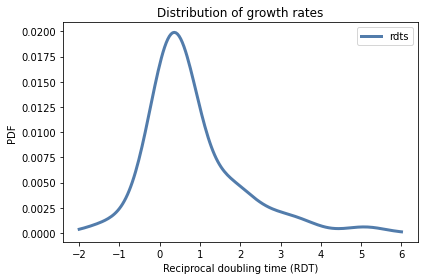

In [14]:
from utils import decorate

pmf_rdt.plot(label='rdts')

decorate(xlabel='Reciprocal doubling time (RDT)',
         ylabel='PDF',
         title='Distribution of growth rates')

In the next section we will use this distribution to simulate tumor growth. 

在下一节中，我们将使用此分布来模拟肿瘤生长。

## Simulation

Now we're ready to run the simulations.
Starting with a small tumor, we'll simulate a series of intervals until the tumor reaches a maximum size.

At the beginning of each simulated interval, we'll choose a value from the distribution of growth rates and compute the size of the tumor at the end.

I chose an interval of 245 days (about 8 months) because that is the
median time between measurements in the data source

For the initial diameter I chose 0.3 cm, because carcinomas smaller than that are less likely to be invasive and less likely to have the blood supply needed for rapid growth (see [this page on carcinoma](http://en.wikipedia.org/wiki/Carcinoma_in_situ)).
For the maximum diameter I chose 20 cm. 



## 模拟

现在我们准备好运行模拟了。
从一个小肿瘤开始，我们将模拟一系列间隔，直到肿瘤达到最大尺寸。

在每个模拟间隔开始时，我们将从生长速率分布中选择一个值，并在结束时计算肿瘤的大小。

我选择了 245 天（大约 8 个月）的间隔，因为那是
数据源中测量之间的中值时间

对于初始直径，我选择了 0.3 厘米，因为小于这个值的癌不太可能是侵袭性的，并且不太可能有快速生长所需的血液供应（参见 [关于癌的此页面](http://en.wikipedia.org/wiki/Carcinoma_in_situ))。
对于最大直径，我选择了 20 厘米。

In [15]:
interval = 245 / 365      # year
min_diameter = 0.3        # cm
max_diameter = 20         # cm

I'll use `calc_volume` to compute the initial and maximum volumes:

我将使用 `calc_volume` 来计算初始和最大体积：

In [16]:
v0 = calc_volume(min_diameter)
vmax = calc_volume(max_diameter)
v0, vmax

(0.014137166941154066, 4188.790204786391)

The following function runs the simulation.

以下函数运行模拟。

In [60]:
import pandas as pd

def simulate_growth(pmf_rdt):
    """Simulate the growth of a tumor."""
    age = 0
    volume = v0
    res = []
    
    while True:
        res.append((age, volume))
        if volume > vmax:
            break

        rdt = pmf_rdt.choice()
        age += interval 
        doublings = rdt * interval
        volume *= 2**doublings
        
    columns = ['age', 'volume']
    sim = pd.DataFrame(res, columns=columns)
    sim['diameter'] = calc_diameter(sim['volume'])
    return sim

`simulate_growth` takes as a parameter a `Pmf` that represents the distribution of RDT.
It initializes the age and volume of the tumor, then runs a loop that simulates one interval at a time.

Each time through the loop, it checks the volume of the tumor and exits if it exceeds `vmax`.

Otherwise it chooses a value from `pmf_rdt` and updates `age` and `volume`.  Since `rdt` is in doublings per year, we multiply by `interval` to compute the number of doublings during each interval.

At the end of the loop, `simulate_growth` puts the results in a `DataFrame` and computes the diameter that corresponds to each volume.

Here's how we call this function:

`simulate_growth` 将代表 RDT 分布的 `Pmf` 作为参数。
它初始化肿瘤的年龄和体积，然后运行一个循环，一次模拟一个间隔。

每次通过循环时，它都会检查肿瘤的体积，如果超过“vmax”则退出。

否则，它会从 `pmf_rdt` 中选择一个值并更新 `age` 和 `volume`。由于“rdt”每年翻倍，我们乘以“间隔”来计算每个间隔内的翻倍数。

在循环结束时，`simulate_growth` 将结果放入`DataFrame` 并计算对应于每个体积的直径。

下面是我们如何调用这个函数：

In [18]:
np.random.seed(17)

In [61]:
sim = simulate_growth(pmf_rdt)
sim

,age,volume,diameter
0,0.000000,0.014137,0.300000
1,0.671233,0.019763,0.335441
2,1.342466,0.053988,0.468921
3,2.013699,0.043183,0.435282
4,2.684932,0.045662,0.443458
5,3.356164,0.060366,0.486704
6,4.027397,0.191384,0.714994
7,4.698630,0.257765,0.789603
8,5.369863,0.532648,1.005728
9,6.041096,0.691185,1.096980


Here are the results for the first few intervals:

以下是前几个间隔的结果：

In [20]:
sim.head(3)

,age,volume,diameter
0,0.000000,0.014137,0.300000
1,0.671233,0.014949,0.305635
2,1.342466,0.019763,0.335441


And the last few intervals.
最后几个间隔。

In [21]:
sim.tail(3)

,age,volume,diameter
43,28.863014,1882.067427,15.318357
44,29.534247,2887.563277,17.667603
45,30.205479,4953.618273,21.149883


To show the results graphically, I'll run 101 simulations:

为了以图形方式显示结果，我将运行 101 次模拟：

In [22]:
np.random.seed(17)

In [23]:
sims = [simulate_growth(pmf_rdt) for _ in range(101)]

And plot the results.

并绘制结果。

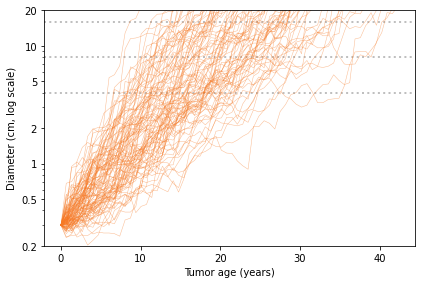

In [24]:
import matplotlib.pyplot as plt

diameters = [4, 8, 16]
for diameter in diameters:
    plt.axhline(diameter,
                color='C5', linewidth=2, ls=':')

for sim in sims:
    plt.plot(sim['age'], sim['diameter'],
             color='C1', linewidth=0.5, alpha=0.5)
    
decorate(xlabel='Tumor age (years)',
         ylabel='Diameter (cm, log scale)',
         ylim=[0.2, 20],
         yscale='log')

yticks = [0.2, 0.5, 1, 2, 5, 10, 20]
plt.yticks(yticks, yticks);

In this figure, each thin, solid line shows the simulated growth of a tumor over time, with diameter on a log scale.
The dotted lines are at 4, 8, and 16 cm.

By reading across the dotted lines, you can get a sense of the distribution of age at each size.
For example, reading across the top line, we see that the age of a 16 cm tumor might be as low 10 years or as high as 40 years, but it is most likely to be between 15 and 30.

To compute this distribution more precisely, we can interpolate the growth curves to see when each one passes through a given size.
The following function takes the results of the simulations and returns the age when each tumor reached a given diameter.

在该图中，每条细实线显示了肿瘤随时间的模拟生长，其直径为对数刻度。
虚线位于 4、8 和 16 厘米处。

通过阅读虚线，您可以了解每种尺寸的年龄分布。
例如，越过顶线，我们看到 16 厘米肿瘤的年龄可能低至 10 年或高达 40 岁，但最有可能在 15 到 30 岁之间。

为了更精确地计算这种分布，我们可以对增长曲线进行插值，以查看每个曲线何时通过给定大小。
以下函数获取模拟结果并返回每个肿瘤达到给定直径时的年龄。

In [25]:
from scipy.interpolate import interp1d

def interpolate_ages(sims, diameter):
    """Estimate the age when each tumor reached a given size."""
    ages = []
    for sim in sims:
        interp = interp1d(sim['diameter'], sim['age'])
        age = interp(diameter)
        ages.append(float(age))
    return ages

We can call this function like this:

我们可以这样调用这个函数：

In [26]:
from empiricaldist import Cdf

ages = interpolate_ages(sims, 15)
cdf = Cdf.from_seq(ages)
print(cdf.median(), cdf.credible_interval(0.9))

22.31854530374061 [13.47056554 34.49632276]


For a tumor 15 cm in diameter, the median age is about 22 years, the 90% credible interval is between 13 and 34 years, and the probability that it formed less than 9 years ago is less than 1%.

对于直径为 15 cm 的肿瘤，中位年龄约为 22 岁，90% 的可信区间在 13 至 34 岁之间，其形成时间小于 9 年的概率小于 1%。

In [27]:
1 - cdf(9.0)

0.9900990099009901

But this result is based on two modeling decisions that are potentially problematic:

* In the simulations, growth rate during each interval is independent of previous growth rates. In reality it is plausible that tumors that have grown quickly in the past are likely to grow quickly in the future. In other words, there is probably a serial correlation in growth rate.

* To convert from linear measure to volume, we assume that tumors are approximately spherical.

In additional experiments, I implemented a simulation that chooses growth rates with serial correlation; the effect is that the fast-growing tumors grow faster and the slow-growing tumors grow slower.
Nevertheless, with moderate correlation (0.5), the probability that a 15 cm tumor is less than 9 years old is only about 1%. 

The assumption that tumors are spherical is probably fine for tumors up to a few centimeters, but not for a tumor with linear dimensions 15.5 x 15 cm.
If, as seems likely, a tumor this size is relatively flat, it might have the same volume as a 6 cm sphere.
But even with this smaller volume and correlation 0.5, the probability that this tumor is less than 9 years old is about 5%.

So even taking into account modeling errors, it is unlikely that such a large tumor could have formed after my correspondent retired from military service.

但是这个结果是基于两个可能存在问题的建模决策：

* 在模拟中，每个区间的增长率与之前的增长率无关。实际上，过去快速生长的肿瘤在未来可能会快速生长，这似乎是合理的。换句话说，增长率可能存在序列相关性。

* 为了从线性测量转换为体积，我们假设肿瘤近似球形。

在其他实验中，我实施了一个模拟，选择具有序列相关性的增长率；效果是快速生长的肿瘤生长得更快，而生长缓慢的肿瘤生长得更慢。
然而，在中等相关性（0.5）的情况下，15 cm 肿瘤小于 9 岁的概率仅为 1% 左右。

肿瘤呈球形的假设可能适用于长达几厘米的肿瘤，但不适用于线性尺寸为 15.5 x 15 厘米的肿瘤。
如果像看起来可能的那样，这种大小的肿瘤相对平坦，它的体积可能与 6 厘米的球体相同。
但即使体积较小且相关性为 0.5，该肿瘤小于 9 年的概率也约为 5%。

因此，即使考虑到建模错误，我的通讯员退役后也不太可能形成这么大的肿瘤。

The following figure shows the distribution of ages for tumors with diameters 4, 8, and 15 cm.

下图显示了直径为 4、8 和 15 cm 的肿瘤的年龄分布。

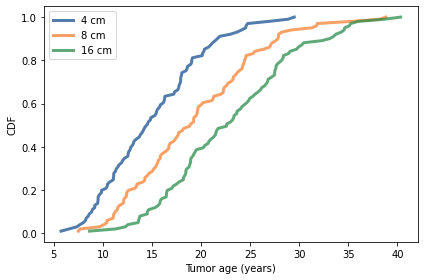

In [28]:
for diameter in diameters:
    ages = interpolate_ages(sims, diameter)
    cdf = Cdf.from_seq(ages)
    cdf.plot(label=f'{diameter} cm')
    
decorate(xlabel='Tumor age (years)',
         ylabel='CDF')

## Approximate Bayesian Calculation

At this point you might wonder why this example is in a book about Bayesian statistics.
We never defined a prior distribution or did a Bayesian update.
Why not? Because we didn't have to.

Instead, we used simulations to compute ages and sizes for a collection of hypothetical tumors.
Then, implicitly, we used the simulation results to form a joint distribution of age and size.
If we select a column from the joint distribution, we get a distribution of size conditioned on age.
If we select a row, we get a distribution of age conditioned on size.

So this example is like the ones we saw in <<_Probability>>: if you have all of the data, you don't need Bayes's theorem; you can compute probabilities by counting.

This example is a first step toward Approximate Bayesian Computation (ABC).
The next example is a second step.

## 近似贝叶斯计算

在这一点上，您可能想知道为什么这个例子出现在一本关于贝叶斯统计的书中。
我们从未定义过先验分布或进行贝叶斯更新。
为什么不？因为我们不必这样做。

相反，我们使用模拟来计算一组假设肿瘤的年龄和大小。
然后，隐含地，我们使用模拟结果来形成年龄和大小的联合分布。
如果我们从联合分布中选择一列，我们会得到一个以年龄为条件的大小分布。
如果我们选择一行，我们会得到一个以大小为条件的年龄分布。

所以这个例子就像我们在<<_Probability>>中看到的那样：如果你有所有的数据，你就不需要贝叶斯定理；您可以通过计数来计算概率。

此示例是迈向近似贝叶斯计算 (ABC) 的第一步。
下一个示例是第二步。

## Counting Cells

This example comes from [this blog post](https://dataorigami.net/blogs/napkin-folding/bayesian-cell-counting), by Cameron Davidson-Pilon.
In it, he models the process biologists use to estimate the concentration of cells in a sample of liquid.
The example he presents is counting cells in a "yeast slurry", which is a mixture of yeast and water used in brewing beer.

There are two steps in the process:

* First, the slurry is diluted until the concentration is low enough that it is practical to count cells.

* Then a small sample is put on a hemocytometer, which is a specialized microscope slide that holds a fixed amount of liquid on a rectangular grid.

The cells and the grid are visible in a microscope, making it possible to count the cells accurately.

As an example, suppose we start with a yeast slurry with unknown concentration of cells.
Starting with a 1 mL sample, we dilute it by adding it to a shaker with 9 mL of water and mixing well.
Then we dilute it again, and then a third time.
Each dilution reduces the concentration by a factor of 10, so three dilutions reduces the concentration by a factor of 1000.

Then we add the diluted sample to the hemocytometer, which has a capacity of 0.0001 mL spread over a 5x5 grid.
Although the grid has 25 squares, it is standard practice to inspect only a few of them, say 5, and report the total number of cells in the inspected squares.


## 计数细胞

这个例子来自 [this blog post](https://dataorigami.net/blogs/napkin-folding/bayesian-cell-counting)，作者是 Cameron Davidson-Pilon。
在其中，他模拟了生物学家用来估计液体样本中细胞浓度的过程。
他提出的例子是对“酵母浆”中的细胞进行计数，酵母浆是用于酿造啤酒的酵母和水的混合物。

该过程有两个步骤：

* 首先，将浆液稀释至浓度足够低，可以进行细胞计数。

* 然后将一个小样本放在血细胞计数器上，这是一种专门的显微镜载玻片，在矩形网格上装有固定量的液体。

在显微镜下可以看到细胞和网格，从而可以准确地计数细胞。

例如，假设我们从细胞浓度未知的酵母浆开始。
从 1 mL 样品开始，我们通过将其添加到装有 9 mL 水的摇床中并充分混合来稀释它。
然后我们再次稀释它，然后第三次。
每次稀释将浓度降低 10 倍，因此 3 次稀释将浓度降低 1000 倍。

然后我们将稀释的样本添加到血细胞计数器中，该血细胞计数器的容量为 0.0001 mL，分布在 5x5 网格上。
虽然网格有 25 个方格，但标准做法是只检查其中的几个，比如 5 个，并报告检查过的方格中的单元格总数。

This process is simple enough, but at every stage there are sources of error:

* During the dilution process, liquids are measured using pipettes that introduce measurement error.

* The amount of liquid in the hemocytometer might vary from the specification.

* During each step of the sampling process, we might select more or less than the average number of cells, due to random variation.

Davidson-Pilon presents a PyMC model that describes these errors.
I'll start by replicating his model; then we'll adapt it for ABC.

Suppose there are 25 squares in the grid, we count 5 of them, and the total number of cells is 49.

这个过程很简单，但在每个阶段都有错误来源：

* 在稀释过程中，使用移液器测量液体会产生测量误差。

* 血细胞计数器中的液体量可能与规格不同。

* 在抽样过程的每一步中，由于随机变化，我们可能会选择多于或少于平均细胞数的细胞。

Davidson-Pilon 提出了一个描述这些错误的 PyMC 模型。
我将从复制他的模型开始；然后我们将其改编为 ABC。

假设网格中有 25 个方格，我们统计其中的 5 个，单元格总数为 49 个。

In [29]:
total_squares = 25
squares_counted = 5
yeast_counted = 49

Here's the first part of the model, which defines the prior distribution of `yeast_conc`, which is the concentration of yeast we're trying to estimate.

`shaker1_vol` is the actual volume of water in the first shaker, which should be 9 mL, but might be higher or lower, with standard deviation 0.05 mL.
`shaker2_vol` and `shaker3_vol` are the volumes in the second and third shakers.

这是模型的第一部分，它定义了 `yeast_conc` 的先验分布，这是我们试图估计的酵母浓度。

`shaker1_vol` 是第一个摇床中的实际水量，应为 9 mL，但可能更高或更低，标准偏差为 0.05 mL。
`shaker2_vol` 和 `shaker3_vol` 是第二个和第三个摇床的体积。

In [30]:
import pymc3 as pm
billion = 1e9

with pm.Model() as model:
    yeast_conc = pm.Normal("yeast conc", 
                           mu=2 * billion, sd=0.4 * billion)

    shaker1_vol = pm.Normal("shaker1 vol", 
                               mu=9.0, sd=0.05)
    shaker2_vol = pm.Normal("shaker2 vol", 
                               mu=9.0, sd=0.05)
    shaker3_vol = pm.Normal("shaker3 vol", 
                               mu=9.0, sd=0.05)

Now, the sample drawn from the yeast slurry is supposed to be 1 mL, but might be more or less.
And similarly for the sample from the first shaker and from the second shaker.
The following variables model these steps.

现在，从酵母浆中提取的样品应该是 1 mL，但可能或多或少。
对于来自第一个振荡器和来自第二个振荡器的样品也是如此。
以下变量对这​​些步骤进行建模。

In [32]:
with model:
    yeast_slurry_vol = pm.Normal("yeast slurry vol",
                                    mu=1.0, sd=0.01)
    shaker1_to_shaker2_vol = pm.Normal("shaker1 to shaker2",
                                    mu=1.0, sd=0.01)
    shaker2_to_shaker3_vol = pm.Normal("shaker2 to shaker3",
                                    mu=1.0, sd=0.01)

Given the actual volumes in the samples and in the shakers, we can compute the effective dilution, `final_dilution`, which should be 1000, but might be higher or lower.

鉴于样品和摇床中的实际体积，我们可以计算有效稀释度“final_dilution”，它应该是 1000，但可能更高或更低。

In [33]:
with model:
    dilution_shaker1 = (yeast_slurry_vol / 
                        (yeast_slurry_vol + shaker1_vol))
    dilution_shaker2 = (shaker1_to_shaker2_vol / 
                        (shaker1_to_shaker2_vol + shaker2_vol))
    dilution_shaker3 = (shaker2_to_shaker3_vol / 
                        (shaker2_to_shaker3_vol + shaker3_vol))
    
    final_dilution = (dilution_shaker1 * 
                      dilution_shaker2 * 
                      dilution_shaker3)

The next step is to place a sample from the third shaker in the chamber of the hemocytomer.
The capacity of the chamber should be 0.0001 mL, but might vary; to describe this variance, we'll use a gamma distribution, which ensures that we don't generate negative values.

下一步是将来自第三个摇床的样品放入血细胞计数器的腔室中。
腔室的容量应为 0.0001 mL，但可能会有所不同；为了描述这种差异，我们将使用伽马分布，以确保我们不会产生负值。

In [34]:
with model:
    chamber_vol = pm.Gamma("chamber_vol", 
                           mu=0.0001, sd=0.0001 / 20)

On average, the number of cells in the chamber is the product of the actual concentration, final dilution, and chamber volume.
But the actual number might vary; we'll use a Poisson distribution to model this variance.

平均而言，腔室中的细胞数量是实际浓度、最终稀释度和腔室体积的乘积。
但实际数字可能会有所不同；我们将使用泊松分布来模拟这种方差。

In [35]:
with model:
    yeast_in_chamber = pm.Poisson("yeast in chamber", 
        mu=yeast_conc * final_dilution * chamber_vol)

Finally, each cell in the chamber will be in one of the squares we count with probability `p=squares_counted/total_squares`.
So the actual count follows a binomial distribution.

最后，腔室中的每个单元格都将位于我们以“p=squares_counted/total_squares”的概率计数的方格之一中。
所以实际计数遵循二项分布。

In [36]:
with model:
    count = pm.Binomial("count", 
                        n=yeast_in_chamber, 
                        p=squares_counted/total_squares,
                        observed=yeast_counted)

With the model specified, we can use `sample` to generate a sample from the posterior distribution.

指定模型后，我们可以使用 `sample` 从后验分布生成样本。

In [37]:
options = dict(return_inferencedata=False)

with model:
    trace = pm.sample(1000, **options)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [chamber_vol, shaker2 to shaker3, shaker1 to shaker2, yeast slurry vol, shaker3 vol, shaker2 vol, shaker1 vol, yeast conc]
>Metropolis: [yeast in chamber]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
The number of effective samples is smaller than 10% for some parameters.


And we can use the sample to estimate the posterior distribution of `yeast_conc` and compute summary statistics.

我们可以使用样本来估计 `yeast_conc` 的后验分布并计算汇总统计量。

In [38]:
posterior_sample = trace['yeast conc'] / billion
cdf_pymc = Cdf.from_seq(posterior_sample)
print(cdf_pymc.mean(), cdf_pymc.credible_interval(0.9))

2.2543040376851406 [1.84198925 2.69247232]


The posterior mean is about 2.3 billion cells per mL, with a 90% credible interval from 1.8 and 2.7.

So far we've been following in Davidson-Pilon's footsteps.
And for this problem, the solution using MCMC is sufficient.
But it also provides an opportunity to demonstrate ABC.

后验平均值约为每毫升 23 亿个细胞，90% 的可信区间为 1.8 和 2.7。

到目前为止，我们一直在追随戴维森-皮隆的脚步。
而对于这个问题，使用 MCMC 的解决方案就足够了。
但它也提供了展示 ABC 的机会。

## Cell Counting with ABC

The fundamental idea of ABC is that we use the prior distribution to generate a sample of the parameters, and then simulate the system for each set of parameters in the sample.

In this case, since we already have a PyMC model, we can use `sample_prior_predictive` to do the sampling and the simulation.

## 使用 ABC 进行细胞计数

ABC的基本思想是我们使用先验分布生成参数的样本，然后对样本中的每一组参数进行系统模拟。

在这种情况下，由于我们已经有了 PyMC 模型，我们可以使用 `sample_prior_predictive` 来进行采样和模拟。

In [62]:
with model:
    prior_sample = pm.sample_prior_predictive(10000)

In [64]:
prior_sample

{'chamber_vol_log__': array([-9.22635997, -9.20797238, -9.2013243 , ..., -9.16765154,
        -9.23409508, -9.12125855]),
 'shaker3 vol': array([9.11966565, 9.00631298, 8.92604781, ..., 9.04843179, 9.00680457,
        8.94607099]),
 'chamber_vol': array([9.84108028e-05, 1.00237080e-04, 1.00905684e-04, ...,
        1.04361310e-04, 9.76525211e-05, 1.09317009e-04]),
 'count': array([24, 51, 48, ..., 60, 41, 49]),
 'shaker2 vol': array([8.98121676, 8.96866641, 8.96809964, ..., 9.01201597, 8.89753567,
        9.03431201]),
 'yeast slurry vol': array([0.99839317, 1.00619959, 1.01621906, ..., 1.00974315, 0.99573719,
        0.99564903]),
 'yeast conc': array([1.29598015e+09, 2.17570208e+09, 1.83733533e+09, ...,
        2.56247958e+09, 2.06335969e+09, 2.42517948e+09]),
 'yeast in chamber': array([117, 235, 198, ..., 292, 184, 268]),
 'shaker1 vol': array([8.9327624 , 8.99644344, 9.02904584, ..., 8.94834156, 8.97742206,
        8.95948942]),
 'shaker2 to shaker3': array([0.99037141, 1.00662278,

The result is a dictionary that contains samples from the prior distribution of the parameters and the prior predictive distribution of `count`.

结果是一个字典，其中包含来自参数的先验分布和“count”的先验预测分布的样本。

In [65]:
count = prior_sample['count']
print(count.mean())

40.0099


In [67]:
len(count)

10000

In [66]:
count

array([24, 51, 48, ..., 60, 41, 49])

Now, to generate a sample from the posterior distribution, we'll select only the elements in the prior sample where the output of the simulation, `count`, matches the observed data, 49.

现在，为了从后验分布生成样本，我们将仅选择先前样本中模拟输出“count”与观察数据 49 匹配的元素。

In [68]:
mask = (count == 49)
mask.sum()

235

In [72]:
len(mask)

10000

We can use `mask` to select the values of `yeast_conc` for the simulations that yield the observed data.

我们可以使用 `mask` 来选择 `yeast_conc` 的值，用于产生观察数据的模拟。

In [69]:
posterior_sample2 = prior_sample['yeast conc'][mask] / billion

And we can use the posterior sample to estimate the CDF of the posterior distribution.

我们可以使用后验样本来估计后验分布的CDF。

In [73]:
posterior_sample2 

array([2.56986678, 2.12203034, 2.41958574, 2.37421404, 2.74407426,
       2.04336833, 2.36045479, 2.41334357, 2.37297422, 1.689426  ,
       1.78258978, 2.31290001, 2.05099349, 2.62691806, 2.56623845,
       2.66163723, 1.87466994, 1.95425175, 2.01605448, 2.13084671,
       2.34826642, 2.16196379, 2.28465047, 1.92135781, 2.35653396,
       2.53642466, 2.50138192, 2.46201429, 2.54750887, 1.91110835,
       2.33250682, 2.20750174, 2.78446232, 2.38719049, 2.43318983,
       2.49873806, 1.96699025, 2.11881135, 2.10849592, 2.4567832 ,
       2.19832634, 2.25263299, 2.02561655, 2.03293449, 2.1731928 ,
       2.70833799, 2.12653172, 2.01061745, 2.00521741, 2.75546823,
       2.38417363, 2.46169423, 2.83862583, 2.53896851, 2.15733647,
       2.08721044, 2.01841107, 1.90866652, 2.23580504, 2.19589209,
       2.11416902, 2.07406957, 2.28243961, 2.24722471, 2.38580802,
       2.23489222, 2.3130158 , 2.24378806, 2.16133462, 2.28871437,
       2.27876232, 2.70782143, 2.60370534, 2.3152005 , 2.51173

In [70]:
cdf_abc = Cdf.from_seq(posterior_sample2)
print(cdf_abc.mean(), cdf_abc.credible_interval(0.9))

2.2809219358999395 [1.87466994 2.74190886]


The posterior mean and credible interval are similar to what we got with MCMC.
Here's what the distributions look like.

后验均值和可信区间与我们使用 MCMC 得到的相似。
这是分布的样子。

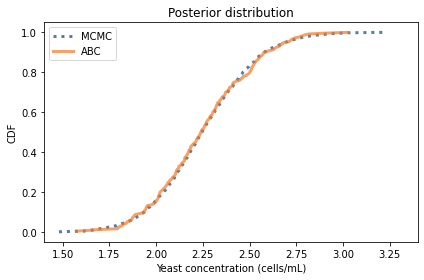

In [44]:
cdf_pymc.plot(label='MCMC', ls=':')
cdf_abc.plot(label='ABC')

decorate(xlabel='Yeast concentration (cells/mL)',
         ylabel='CDF',
         title='Posterior distribution',
         xlim=(1.4, 3.4))

The distributions are similar, but the results from ABC are noisier because the sample size is smaller.

分布相似，但 ABC 的结果更嘈杂，因为样本量更小。

## When Do We Get to the Approximate Part?

The examples so far are similar to Approximate Bayesian Computation, but neither of them demonstrates all of the elements of ABC.
More generally, ABC is characterized by:

1. A prior distribution of parameters.

2. A simulation of the system that generates the data.

3. A criterion for when we should accept that the output of the simulation matches the data.

The kidney tumor example was atypical because we didn't represent the prior distribution of age explicitly.
Because the simulations generate a joint distribution of age and size, we we able to get the marginal posterior distribution of age directly from the results.

The yeast example is more typical because we represented the distribution of the parameters explicitly.
But we accepted only simulations where the output matches the data exactly.

The result is approximate in the sense that we have a sample from the posterior distribution rather than the posterior distribution itself.
But it is not approximate in the sense of Approximate Bayesian Computation, which typically accepts simulations where the output matches the data only approximately.

## 我们什么时候到达近似部分？

到目前为止的示例类似于近似贝叶斯计算，但它们都没有展示 ABC 的所有元素。
更一般地说，ABC 的特点是：

1. 参数的先验分布。

2. 生成数据的系统的模拟。

3. 何时我们应该接受模拟输出与数据匹配的标准。

肾肿瘤的例子是非典型的，因为我们没有明确表示年龄的先验分布。
因为模拟生成了年龄和大小的联合分布，我们能够直接从结果中获得年龄的边际后验分布。

酵母的例子更典型，因为我们明确地表示了参数的分布。
但我们只接受输出与数据完全匹配的模拟。

结果是近似的，因为我们有来自后验分布而不是后验分布本身的样本。
但它不是近似贝叶斯计算意义上的近似值，它通常接受输出仅与数据近似匹配的模拟。

To show how that works, I will extend the yeast example with an approximate matching criterion.

In the previous section, we accepted a simulation if the output is precisely 49 and rejected it otherwise.
As a result, we got only a few hundred samples out of 10,000 simulations, so that's not very efficient.

We can make better use of the simulations if we give "partial credit" when the output is close to 49.
But how close?  And how much credit?

One way to answer that is to back up to the second-to-last step of the simulation, where we know the number of cells in the chamber, and we use the binomial distribution to generate the final count.

If there are `n` cells in the chamber, each has a probability `p` of being counted, depending on whether it falls in one of the squares in the grid that get counted.

We can extract `n` from the prior sample, like this:

为了展示它是如何工作的，我将使用近似匹配标准扩展酵母示例。

在上一节中，如果输出正好是 49，我们接受一个模拟，否则拒绝它。
结果，我们在 10,000 次模拟中只得到了几百个样本，因此效率不高。

如果我们在输出接近 49 时给予“部分信用”，我们可以更好地利用模拟。
但是有多近呢？多少信用？

回答这个问题的一种方法是回到模拟的倒数第二个步骤，我们知道腔室中的细胞数量，并且我们使用二项分布来生成最终计数。

如果腔室中有“n”个单元格，则每个单元格被计数的概率为“p”，具体取决于它是否落在网格中被计数的正方形之一中。

我们可以从先前的样本中提取“n”，如下所示：

In [45]:
n = prior_sample['yeast in chamber']
n.shape

(10000,)

And compute `p` like this:

并像这样计算`p`：

In [46]:
p = squares_counted/total_squares
p

0.2

Now here's the idea: we'll use the binomial distribution to compute the likelihood of the data, `yeast_counted`, for each value of `n` and the fixed value of `p`.

现在的想法是：我们将使用二项分布来计算数据的似然性，“yeast_counted”，对于“n”的每个值和“p”的固定值。

In [47]:
from scipy.stats import binom

likelihood = binom(n, p).pmf(yeast_counted).flatten()

In [48]:
likelihood.shape

(10000,)

When the expected count, `n * p`, is close to the actual count, `likelihood` is relatively high; when it is farther away, `likelihood` is lower.

The following is a scatter plot of these likelihoods versus the expected counts.

当预期计数`n * p`接近实际计数时，`likelihood`相对较高；距离越远，“可能性”越低。

以下是这些可能性与预期计数的散点图。

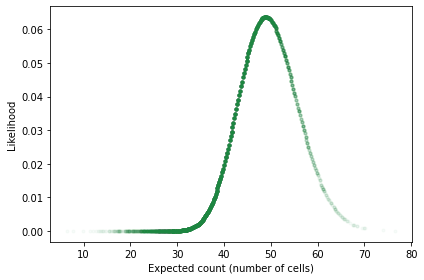

In [49]:
plt.plot(n*p, likelihood, '.', alpha=0.03, color='C2')

decorate(xlabel='Expected count (number of cells)',
         ylabel='Likelihood')

We can't use these likelihoods to do a Bayesian update because they are incomplete; that is, each likelihood is the probability of the data given `n`, which is the result of a single simulation.

But we *can* use them to weight the results of the simulations.
Instead of requiring the output of the simulation to match the data exactly, we'll use the likelihoods to give partial credit when the output is close.

Here's how: I'll construct a `Pmf` that contains yeast concentrations as quantities and the likelihoods as unnormalized probabilities.


我们不能使用这些可能性来进行贝叶斯更新，因为它们是不完整的；也就是说，每个可能性都是给定“n”的数据的概率，这是单个模拟的结果。

但是我们*可以*使用它们来加权模拟结果。
我们不要求模拟的输出与数据完全匹配，而是在输出接近时使用可能性来给予部分信用。

方法如下：我将构建一个“Pmf”，其中包含酵母浓度作为数量和可能性作为非标准化概率。

In [50]:
qs = prior_sample['yeast conc'] / billion
ps = likelihood
posterior_pmf = Pmf(ps, qs)

In this `Pmf`, values of `yeast_conc` that yield outputs close to the data map to higher probabilities.
If we sort the quantities and normalize the probabilities, the result is an estimate of the posterior distribution.

在这个“Pmf”中，产生接近数据的输出的“yeast_conc”值映射到更高的概率。
如果我们对数量进行排序并对概率进行归一化，则结果是对后验分布的估计。

In [51]:
posterior_pmf.sort_index(inplace=True)
posterior_pmf.normalize()

print(posterior_pmf.mean(), posterior_pmf.credible_interval(0.9)) 

2.273277867400659 [1.85026725 2.71995848]


The posterior mean and credible interval are similar to the values we got from MCMC.
And here's what the posterior distributions look like.

后验均值和可信区间与我们从 MCMC 获得的值相似。
这就是后验分布的样子。

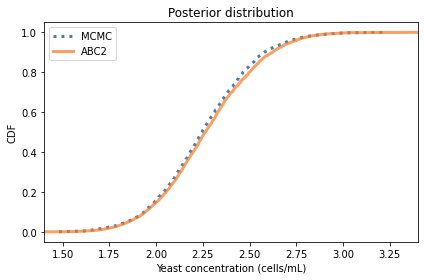

In [52]:
cdf_pymc.plot(label='MCMC', ls=':')
#cdf_abc.plot(label='ABC')
posterior_pmf.make_cdf().plot(label='ABC2')

decorate(xlabel='Yeast concentration (cells/mL)',
         ylabel='CDF',
         title='Posterior distribution',
         xlim=(1.4, 3.4))

The distributions are similar, but the results from MCMC are a little noisier.
In this example, ABC is more efficient than MCMC, requiring less computation to generate a better estimate of the posterior distribution.
But that's unusual; usually ABC requires a lot of computation.
For that reason, it is generally a method of last resort.

分布相似，但 MCMC 的结果有点嘈杂。
在这个例子中，ABC 比 MCMC 更有效，需要更少的计算来生成更好的后验分布估计。
但这很不寻常。通常 ABC 需要大量的计算。
出于这个原因，它通常是最后的手段。

## Summary

In this chapter we saw two examples of Approximate Bayesian Computation (ABC), based on simulations of tumor growth and cell counting.

The definitive elements of ABC are:

1. A prior distribution of parameters.

2. A simulation of the system that generates the data.

3. A criterion for when we should accept that the output of the simulation matches the data.

ABC is particularly useful when the system is too complex to model with tools like PyMC.
For example, it might involve a physical simulation based on differential equations.
In that case, each simulation might require substantial computation, and many simulations might be needed to estimate the posterior distribution.

Next, you'll have a chance to practice with one more example.

## 概括

在本章中，我们看到了基于肿瘤生长和细胞计数模拟的近似贝叶斯计算 (ABC) 的两个示例。

ABC 的最终要素是：

1. 参数的先验分布。

2. 生成数据的系统的模拟。

3. 何时我们应该接受模拟输出与数据匹配的标准。

当系统过于复杂而无法使用 PyMC 等工具建模时，ABC 特别有用。
例如，它可能涉及基于微分方程的物理模拟。
在这种情况下，每个模拟都可能需要大量计算，并且可能需要许多模拟来估计后验分布。

接下来，您将有机会使用另一个示例进行练习。

## Exercises

**Exercise:** This exercise is based on [a blog post by Rasmus Bååth](http://www.sumsar.net/blog/2014/10/tiny-data-and-the-socks-of-karl-broman), which is motivated by a tweet from Karl Broman, who wrote:

> That the first 11 socks in the laundry are distinct suggests that there are a lot of socks.

Suppose you pull 11 socks out of the laundry and find that no two of them make a matched pair.  Estimate the number of socks in the laundry.

To solve this problem, we'll use the model Bååth suggests, which is based on these assumptions:

* The laundry contains some number of pairs of socks, `n_pairs`, plus some number of odd (unpaired) socks, `n_odds`.

* The pairs of socks are different from each other and different from the unpaired socks; in other words, the number of socks of each type is either 1 or 2, never more.

We'll use the prior distributions Bååth suggests, which are:

* The number of socks follows a negative binomial distribution with mean 30 and standard deviation 15.

* The proportion of socks that are paired follows a beta distribution with parameters `alpha=15` and `beta=2`.

In the notebook for this chapter, I'll define these priors.  Then you can simulate the sampling process and use ABC to estimate the posterior distributions.

**练习：** 本练习基于 [Rasmus Bååth 的博客文章](http://www.sumsar.net/blog/2014/10/tiny-data-and-the-socks-of-karl- broman)，这是由 Karl Broman 的一条推文所激发的，他写道：

> 洗衣店的前 11 只袜子是不同的，这表明有很多袜子。

假设你从洗衣房里拿出 11 只袜子，发现其中没有两只是配对的。估计洗衣房里的袜子数量。

为了解决这个问题，我们将使用 Bååth 建议的模型，该模型基于以下假设：

* 洗衣房包含若干双袜子，`n_pairs`，加上一些奇数（未配对）袜子，`n_odds`。

* 成对的袜子相互不同，与未成对的袜子不同；换句话说，每种类型的袜子数量不是 1 就是 2，永远不会更多。

我们将使用 Bååth 建议的先验分布，它们是：

* 袜子数量服从负二项分布，均值为 30，标准差为 15。

* 成对的袜子比例遵循 beta 分布，参数为 `alpha=15` 和 `beta=2`。

在本章的笔记本中，我将定义这些先验。然后您可以模拟采样过程并使用 ABC 来估计后验分布。

To get you started, I'll define the priors.

为了让你开始，我将定义先验。

In [53]:
from scipy.stats import nbinom, beta

mu = 30
p = 0.8666666
r = mu * (1-p) / p

prior_n_socks = nbinom(r, 1-p)
prior_n_socks.mean(), prior_n_socks.std()

(30.0, 14.999996250001402)

In [54]:
prior_prop_pair = beta(15, 2)
prior_prop_pair.mean()

0.8823529411764706

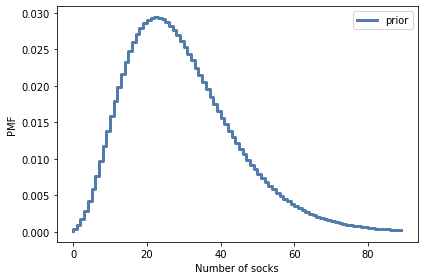

In [55]:
qs = np.arange(90)
ps = prior_n_socks.pmf(qs)
pmf = Pmf(ps, qs)
pmf.normalize()

pmf.plot(label='prior', drawstyle='steps')

decorate(xlabel='Number of socks',
         ylabel='PMF')

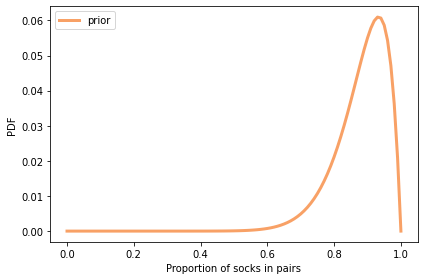

In [56]:
from utils import pmf_from_dist

qs = np.linspace(0, 1, 101)
pmf = pmf_from_dist(prior_prop_pair, qs)
pmf.plot(label='prior', color='C1')

decorate(xlabel='Proportion of socks in pairs',
         ylabel='PDF')

We can sample from the prior distributions like this:

我们可以像这样的先验分布中采样：

In [57]:
n_socks = prior_n_socks.rvs()
prop_pairs = prior_prop_pair.rvs()

n_socks, prop_pairs

(18, 0.9043692425391451)

And use the values to compute `n_pairs` and `n_odds`:

并使用这些值来计算 `n_pairs` 和 `n_odds`：

In [58]:
n_pairs = np.round(n_socks//2 * prop_pairs)
n_odds = n_socks - n_pairs*2

n_pairs, n_odds

(8.0, 2.0)

Now you take it from there.

In [74]:
# Solution goes here

# Solution

n_pairs = 9
n_odds = 5

socks = np.append(np.arange(n_pairs), 
                  np.arange(n_pairs + n_odds))

print(socks)

[ 0  1  2  3  4  5  6  7  8  0  1  2  3  4  5  6  7  8  9 10 11 12 13]


In [75]:
# Solution goes here

# Click to hide# Solution

picked_socks = np.random.choice(socks, size=11, replace=False)
picked_socks

array([ 9,  0, 13,  2,  6,  4,  2,  5,  8,  6,  1])

In [76]:
# Solution goes here

# Solution

values, counts = np.unique(picked_socks, return_counts=True)
values

array([ 0,  1,  2,  4,  5,  6,  8,  9, 13])

In [77]:
# Solution goes here

# Solution

counts

array([1, 1, 2, 1, 1, 2, 1, 1, 1])

In [78]:
# Solution goes here

# Solution

solo = np.sum(counts==1)
pairs = np.sum(counts==2)

solo, pairs

(7, 2)

In [80]:
# Solution goes here

# Solution
# Click to hide# Solution

def pick_socks(n_pairs, n_odds, n_pick):
    socks = np.append(np.arange(n_pairs), 
                      np.arange(n_pairs + n_odds))
    
    picked_socks = np.random.choice(socks, 
                                    size=n_pick, 
                                    replace=False)
    
    values, counts = np.unique(picked_socks, 
                               return_counts=True)
    pairs = np.sum(counts==2)
    odds = np.sum(counts==1)
    return pairs, odds

In [81]:
# Solution goes here
# Solution

pick_socks(n_pairs, n_odds, 11)

(2, 7)

In [82]:
# Solution goes here
# Click to hide# Solution

data = (0, 11)
res = []
for i in range(10000):
    n_socks = prior_n_socks.rvs()
    if n_socks < 11:
        continue
    prop_pairs = prior_prop_pair.rvs()
    n_pairs = np.round(n_socks//2 * prop_pairs)
    n_odds = n_socks - n_pairs*2
    result = pick_socks(n_pairs, n_odds, 11)
    if result == data:
        res.append((n_socks, n_pairs, n_odds))

len(res)

1177

In [83]:
# Solution goes here
# Solution

columns = ['n_socks', 'n_pairs', 'n_odds']
results = pd.DataFrame(res, columns=columns)
results.head()

,n_socks,n_pairs,n_odds
0,39,18.0,3.0
1,50,15.0,20.0
2,42,17.0,8.0
3,48,22.0,4.0
4,35,17.0,1.0


In [84]:
# Solution goes here
# Solution

qs = np.arange(15, 100)
posterior_n_socks = Pmf.from_seq(results['n_socks'])
print(posterior_n_socks.median(),
      posterior_n_socks.credible_interval(0.9))

43.0 [26. 74.]


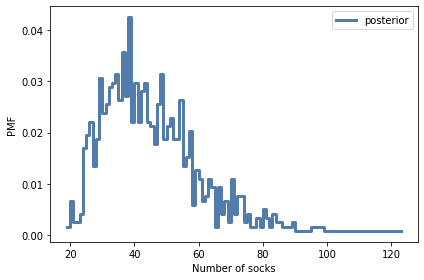

In [85]:
# Solution goes here
# Solution

posterior_n_socks.plot(label='posterior', drawstyle='steps')

decorate(xlabel='Number of socks',
         ylabel='PMF')